In [61]:
import torch 
ensbn = 20
stride = [16384,]
mft = [1] # 10, 15, 20
bmk = [0, 1]
lt = 32

long_context = []

for s in stride:
    for m in mft:
        for l in [0,]:
            for b in bmk:
                long_context.append(torch.load(f'../../cache/llama/ensemble_ppt/qkvout_s{s}_k512_ensbn{ensbn}_query_mft{m}_bmk{b}_lt{lt}__ftdNonel{l}.pth', map_location=torch.device('cpu')))


In [62]:
long_context[0]

{'q': tensor([[[[ 0.4766, -0.5234,  0.3008,  ..., -1.1094,  0.7539,  0.1748],
           [ 0.6992, -0.7070,  0.3145,  ..., -1.0938,  0.9023,  0.1147],
           [-0.8750,  0.3438, -0.2988,  ..., -1.9297,  3.2188, -1.8516],
           ...,
           [-0.1055,  0.4434, -0.1465,  ..., -1.9375,  0.1875, -0.1641],
           [ 0.2500,  0.7852,  0.5391,  ..., -1.4609, -0.4805,  0.6328],
           [ 0.0342,  1.2422,  0.4961,  ..., -2.0312, -0.4141, -0.3008]],
 
          [[ 4.9375, -0.7773,  0.4531,  ...,  0.1738,  0.4316,  0.7852],
           [ 6.0000, -1.5469,  0.5820,  ...,  0.0101,  0.3203,  0.5195],
           [ 1.1641, -0.2168,  0.8164,  ..., -0.7227,  1.0703,  1.2500],
           ...,
           [ 1.6641, -1.0234, -1.0234,  ...,  0.1748, -1.4688,  0.0771],
           [ 0.7969, -0.2754,  0.2129,  ...,  0.9453, -1.2188,  0.2402],
           [ 1.0000, -0.0981, -0.8711,  ...,  0.7539,  0.3809, -1.5156]],
 
          [[-0.0261, -0.3281, -0.8086,  ..., -0.3516,  0.5469, -1.2734],
        

In [75]:
def find_head_padding_idx(attn_mask):
    filtered_mask = attn_mask!=9999999
    is_zero = filtered_mask.sum(-2) == 0 # 0 : 999999 인 위치
    is_zero_int = is_zero.int()
    # Create a mask to check if there are any True values in each row
    any_true = is_zero.any(dim=1)

    # Compute the first True index only for rows that contain at least one True
    first_true_indices = torch.where(any_true, torch.argmax(is_zero_int, dim=1), torch.tensor(-1))
    # Here, -1 could be used as a placeholder for rows with no True values
    first_true_indices[first_true_indices==-1]=attn_mask.shape[-1]

    max = first_true_indices.max()
    min = first_true_indices.min()
    avg = torch.mean(first_true_indices, dtype=float)
    print(first_true_indices)
    print(max)
    print(min)
    print(avg)

In [76]:
find_head_padding_idx(long_context[0]['indices'])

tensor([826, 603, 709, 750, 772, 880, 797, 569, 642, 750, 935, 936, 825, 441,
        593, 683, 641, 803, 691, 916, 776, 602, 750, 717, 676, 583, 727, 363,
        738, 839, 656, 534])
tensor(936)
tensor(363)
tensor(710.0938, dtype=torch.float64)


In [64]:
filtered_mask.shape

torch.Size([32, 512, 936])

In [81]:
filtered_mask = long_context[0]['indices']!=9999999
is_zero = filtered_mask.sum(-2) == 0 # 0 : 999999 인 위치

In [79]:
is_zero.shape

torch.Size([32, 936])

In [80]:
is_zero

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [68]:
is_zero_int = is_zero.int()
# Create a mask to check if there are any True values in each row
any_true = is_zero.any(dim=1)

# Compute the first True index only for rows that contain at least one True
first_true_indices = torch.where(any_true, torch.argmax(is_zero_int, dim=1), torch.tensor(-1))
# Here, -1 could be used as a placeholder for rows with no True values

print(first_true_indices)

tensor([826, 603, 709, 750, 772, 880, 797, 569, 642, 750, 935,  -1, 825, 441,
        593, 683, 641, 803, 691, 916, 776, 602, 750, 717, 676, 583, 727, 363,
        738, 839, 656, 534])


In [55]:
columns_with_all_zeros = torch.all(is_zero, dim=0)
columns_with_all_zeros.shape

torch.Size([927])

In [49]:
first_column_with_all_zeros = torch.nonzero(columns_with_all_zeros, as_tuple=True)
first_column_with_all_zeros

(tensor([], dtype=torch.int64),)

In [ ]:
def find_first_32000(tensor):
    filtered_mask = tensor != 9999999

    # print(filtered_mask.shape, filtered_mask, filtered_mask.sum(-2).shape, )
    # print(filtered_mask.sum(-2))

    is_zero = filtered_mask.sum(-2) == 0

    # Determine which columns have all zeros
    columns_with_all_zeros = torch.all(is_zero, dim=0)

    # Find the first index where all values in a column are zero
    first_column_with_all_zeros = torch.nonzero(columns_with_all_zeros, as_tuple=True)

    # If there is at least one column with all zeros, get the first one
    if len(first_column_with_all_zeros[0]) > 0:
        first_index = first_column_with_all_zeros[0][0].item()  # Get the index of the first such column
    else:
        first_index = -1  # If no columns contain all zeros

    print("First index where all values are zero:", first_index)

In [32]:
import torch
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Function to plot a grid of heatmaps for attention maps
def plot_attention_maps(tensor, cmap='rainbow'):
    num_attention_maps = tensor.shape[0]
    grid_cols = math.ceil(math.sqrt(num_attention_maps))
    grid_rows = math.ceil(num_attention_maps / grid_cols)
    mask = (tensor == 9999999)
    tensor = torch.where(mask, -1, tensor)
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        if i < tensor.shape[0]:
            sns.heatmap(tensor[i][:], ax=ax, cmap=cmap, cbar=True)
            ax.set_title(f'Head {i+1} {tensor[i].shape}')
            ax.axis('off')  # Optional: Hide the axis ticks
        else:
            ax.axis('off')  # Hide unused plots
    plt.tight_layout()
    plt.show()

In [33]:
long_context[0]

{'q': tensor([[[[ 0.1309, -0.7539,  1.3359,  ..., -0.5312,  0.2080, -0.7930],
           [ 0.5781, -0.5312,  0.7461,  ..., -0.7578,  0.4082, -0.8594],
           [ 0.7266, -0.5820,  0.7578,  ..., -0.7578,  0.4082, -0.8594],
           ...,
           [-1.3047, -1.9062, -1.8281,  ..., -0.6836,  0.1631, -0.8828],
           [-0.7891, -2.2812, -2.5000,  ..., -1.3359,  0.6719, -1.4375],
           [-0.2461, -1.9297, -2.2344,  ..., -1.2266,  0.6641, -1.3438]],
 
          [[ 0.5742,  0.1260, -1.4844,  ..., -0.5234,  0.3145, -0.5078],
           [ 2.4062,  1.7031, -0.8047,  ..., -0.2422,  0.1660, -0.2275],
           [ 2.1562,  1.5000, -0.8711,  ..., -0.2422,  0.1660, -0.2275],
           ...,
           [ 0.1260, -0.2441,  0.2275,  ..., -0.1855, -0.4316, -0.0732],
           [-0.0078,  0.0085,  0.4043,  ...,  0.1680, -0.4629,  0.1777],
           [-0.0474,  0.1621,  0.5312,  ...,  0.1543, -0.3867,  0.1572]],
 
          [[-0.7812, -0.7305, -0.7031,  ..., -0.4277, -0.3750, -0.3691],
        

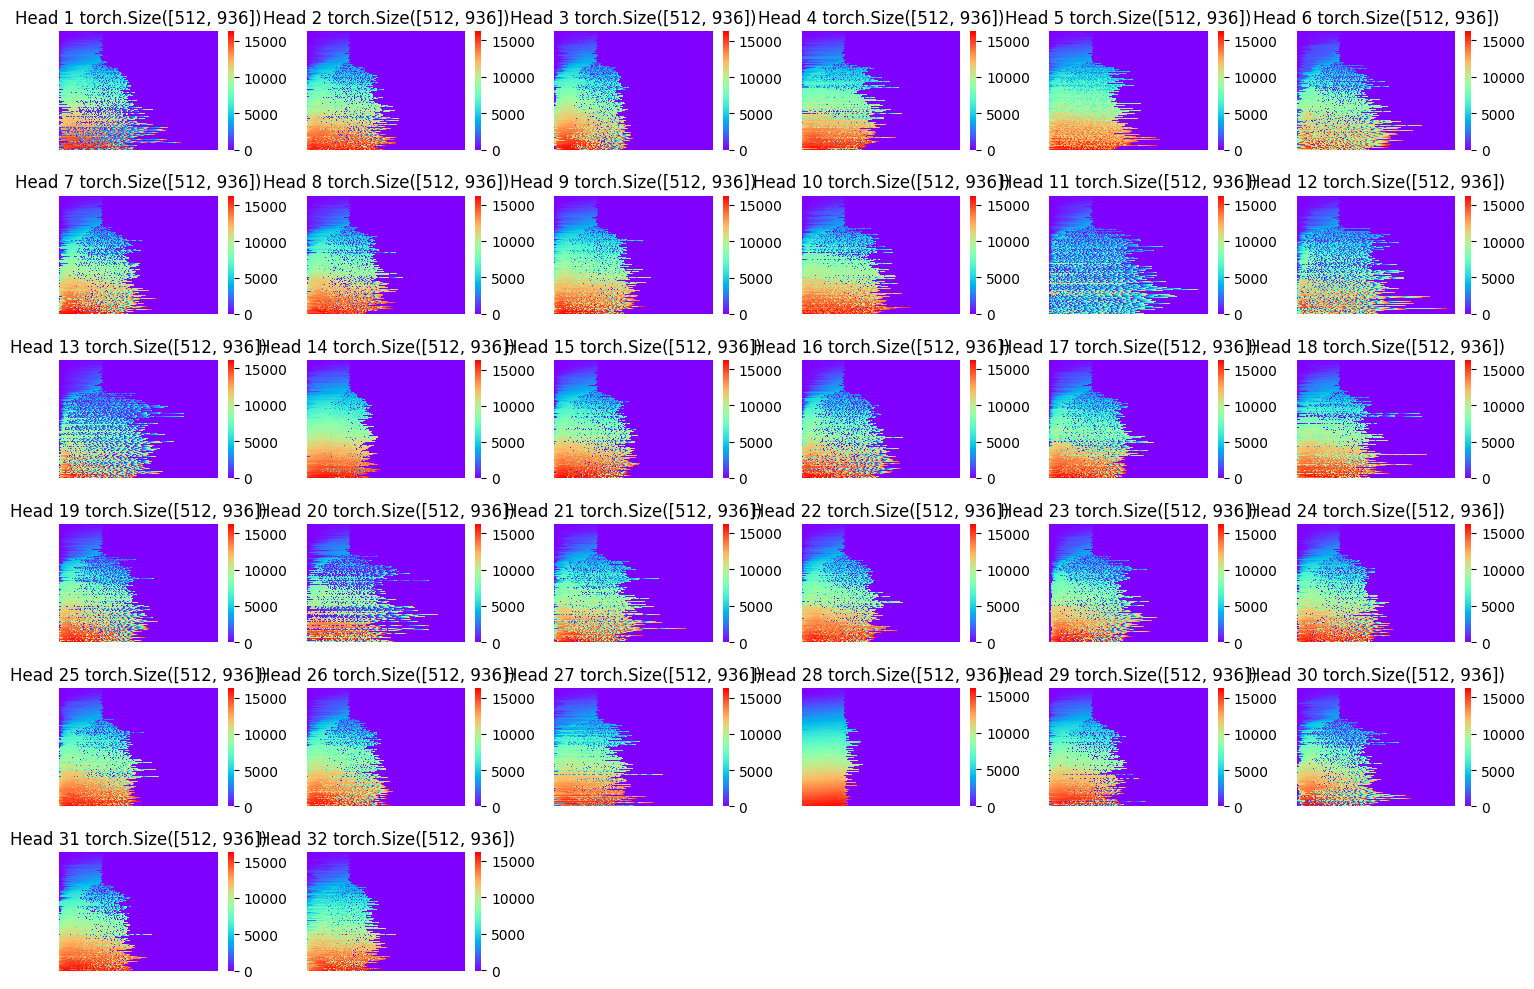

In [22]:
plot_attention_maps(long_context[0]['indices'])

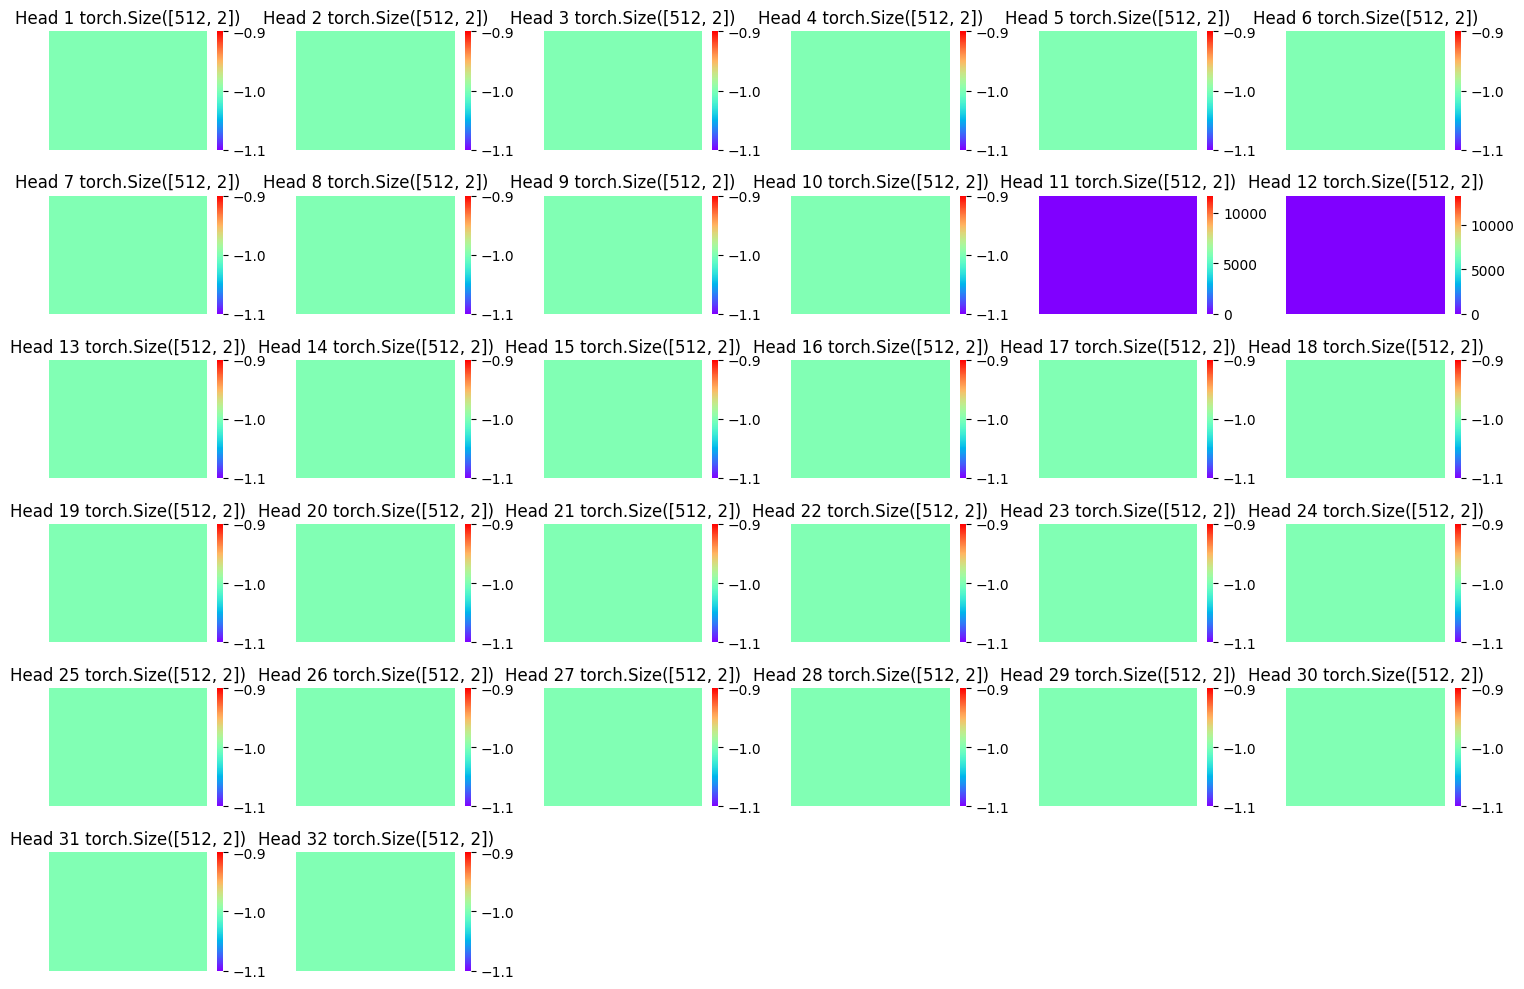

In [26]:
plot_attention_maps(long_context[0]['indices'][:,:,-2:])


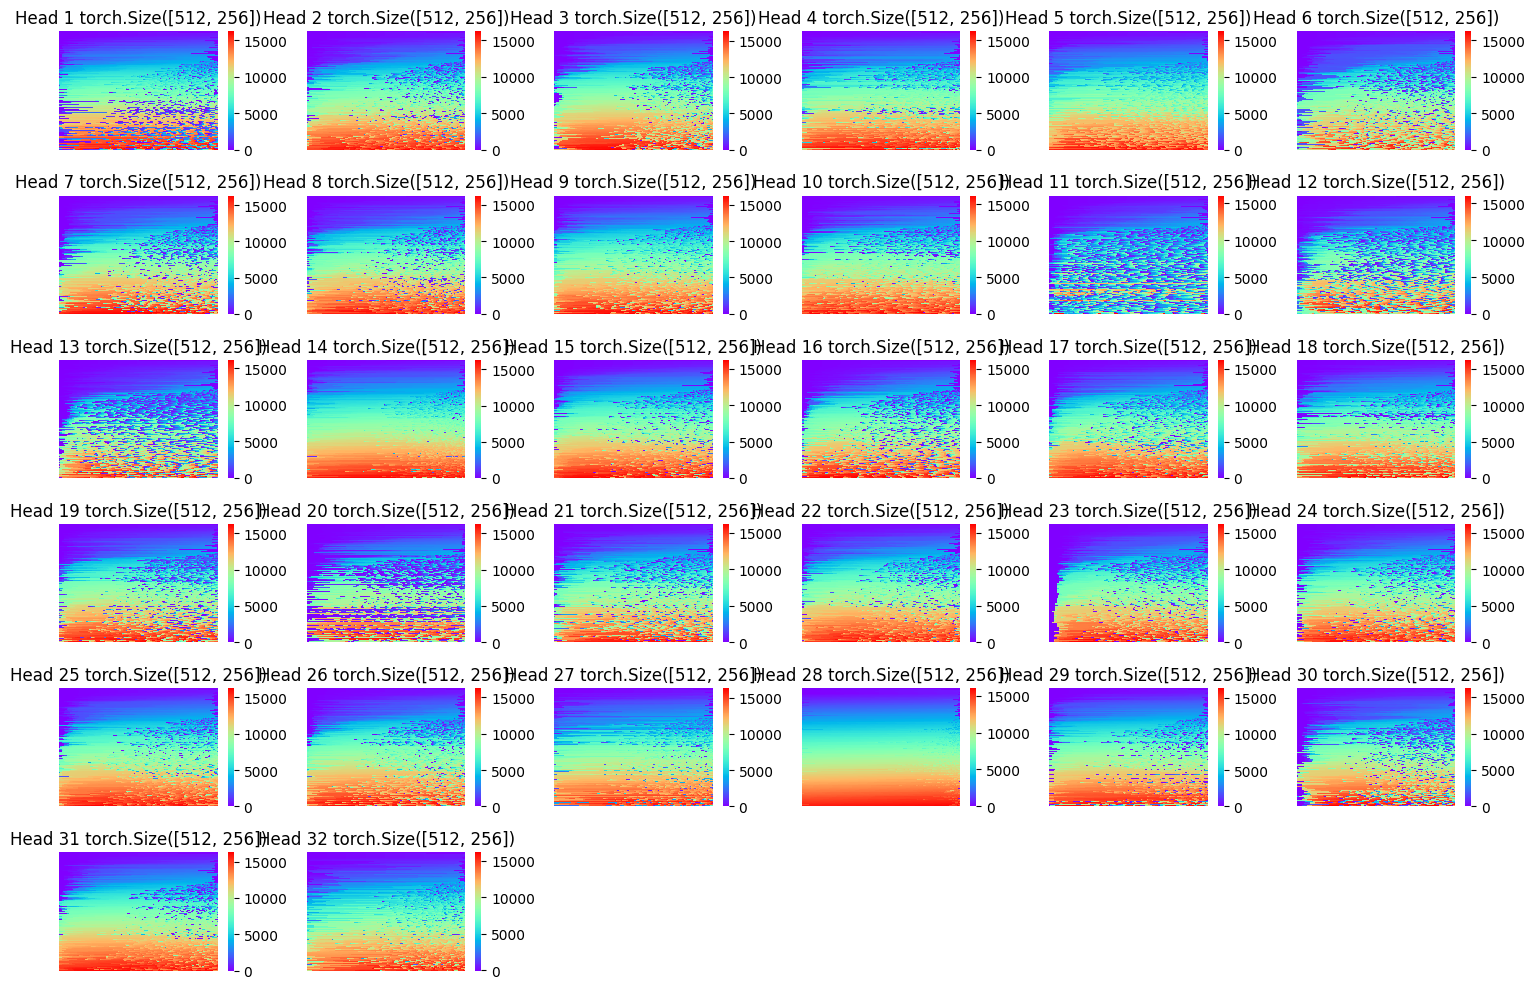

In [27]:
plot_attention_maps(long_context[1]['indices'])

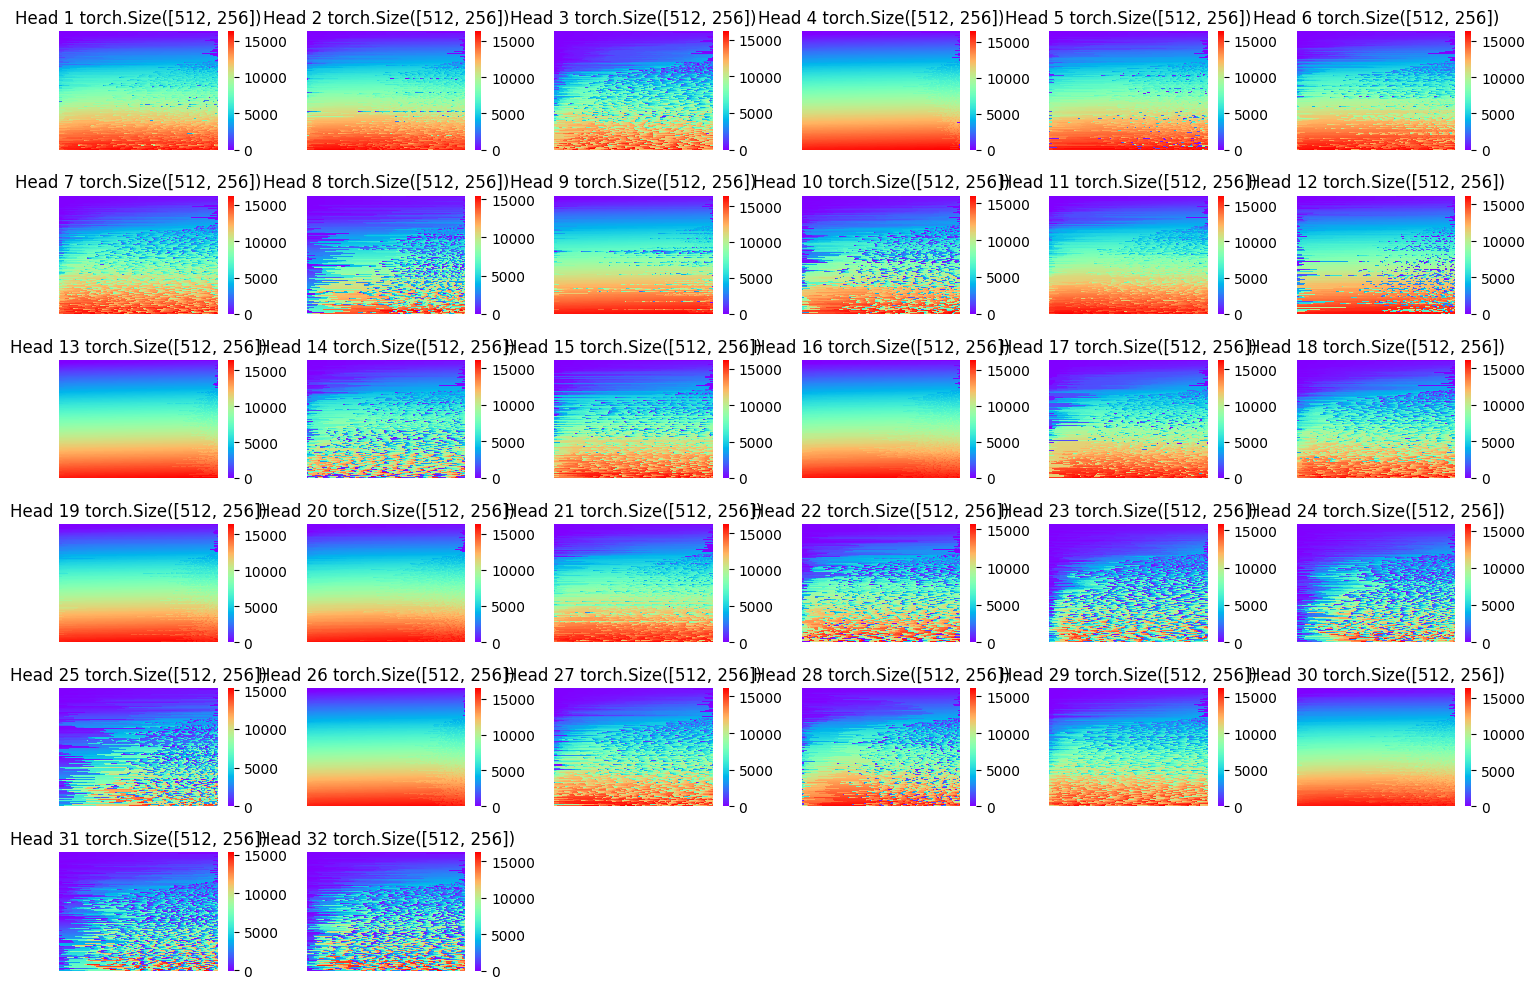

In [14]:
plot_attention_maps(long_context[1]['indices'])


In [23]:
import torch 
ensbn = 20
stride = [16384,]
mft = [1] # 10, 15, 20
# bmk = [0, 1]
lt = 32

default = []

for s in stride:
    for m in mft:
        for l in [31,]:
            for b in bmk:
                default.append(torch.load(f'../../cache/llama/default/qkvout_s{s}_k512_l{l}.pth', map_location=torch.device('cpu')))


In [24]:
default[0]

{'q': tensor([[[[ 4.7656e-01, -5.2344e-01,  3.0078e-01,  ..., -1.1094e+00,
             7.5391e-01,  1.7480e-01],
           [ 6.9922e-01, -7.0703e-01,  3.1445e-01,  ..., -1.0938e+00,
             9.0234e-01,  1.1475e-01],
           [-8.7500e-01,  3.4375e-01, -2.9883e-01,  ..., -1.9297e+00,
             3.2188e+00, -1.8516e+00],
           ...,
           [ 3.5156e-02,  4.2969e-01, -9.7656e-02,  ..., -1.8906e+00,
             1.7969e-01, -2.5977e-01],
           [ 4.3555e-01,  6.9141e-01,  2.8516e-01,  ..., -1.8594e+00,
            -2.6172e-01,  7.5781e-01],
           [ 1.8652e-01,  1.1484e+00,  4.2383e-01,  ..., -2.0469e+00,
            -3.6328e-01, -4.7852e-01]],
 
          [[ 4.9375e+00, -7.7734e-01,  4.5312e-01,  ...,  1.7383e-01,
             4.3164e-01,  7.8516e-01],
           [ 6.0000e+00, -1.5469e+00,  5.8203e-01,  ...,  1.0071e-02,
             3.2031e-01,  5.1953e-01],
           [ 1.1641e+00, -2.1680e-01,  8.1641e-01,  ..., -7.2266e-01,
             1.0703e+00,  1.2500e+

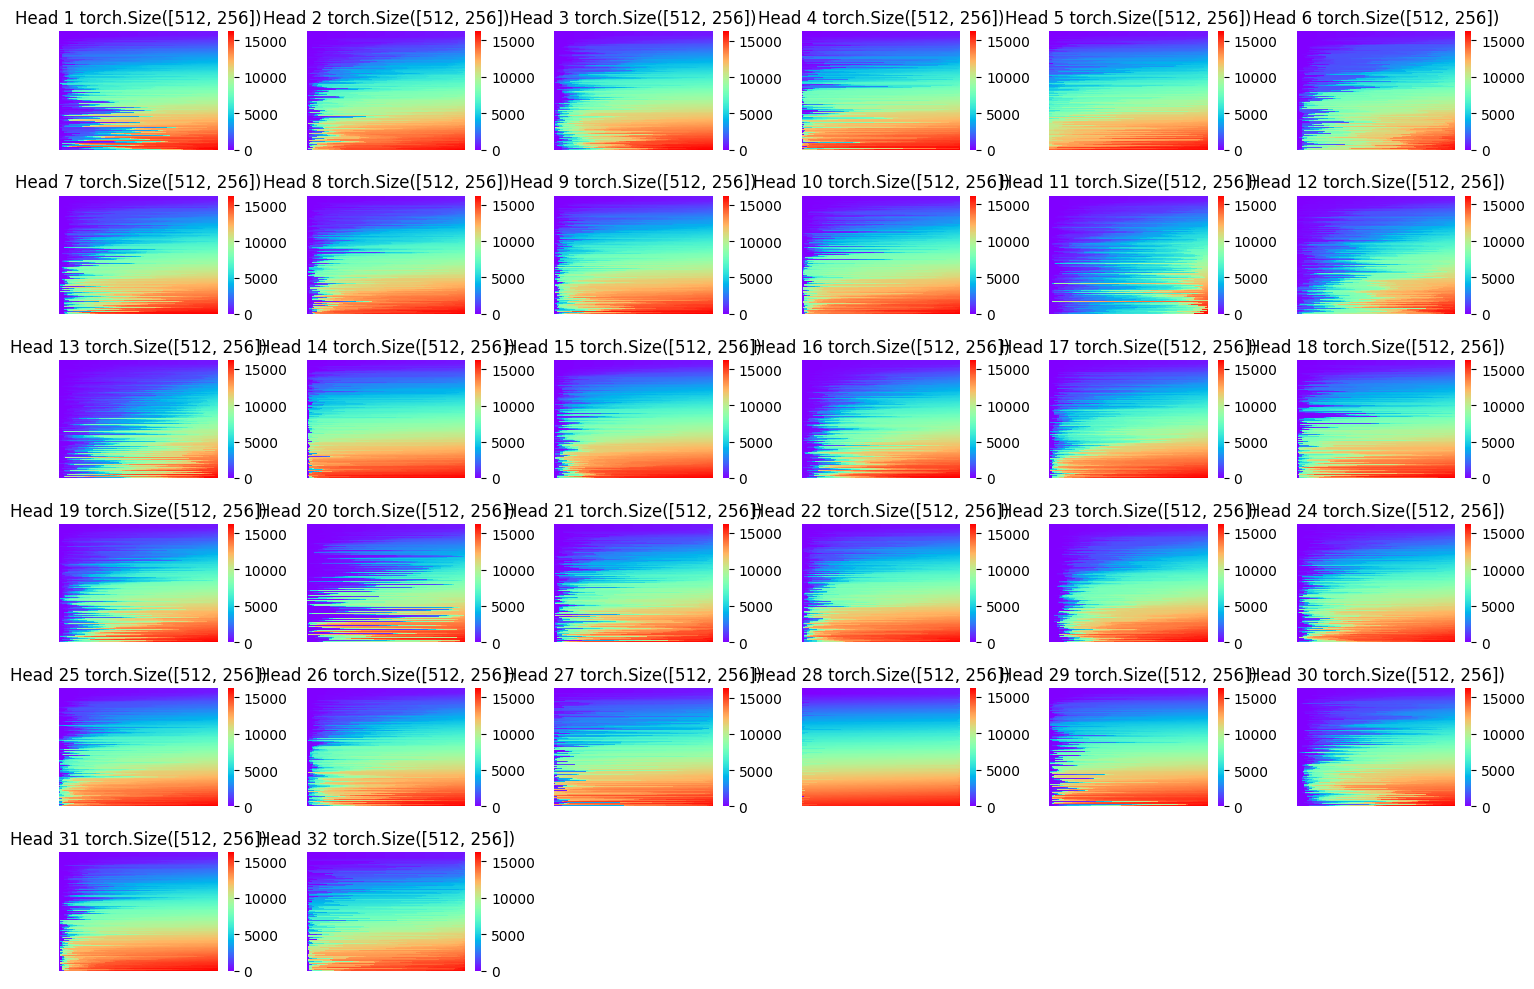

In [25]:
plot_attention_maps(default[0]['indices'])


In [19]:
import torch 
ensbn = 20
stride = [12288,]
mft = [1] # 10, 15, 20
bmk = [0, 1]
lt = 32

long_context = []

for s in stride:
    for m in mft:
        for l in [0,]:
            for b in bmk:
                long_context.append(torch.load(f'../../cache/llama/ensemble/qkvout_s{s}_k512_ensbn{ensbn}_query_mft{m}_bmk{b}_lt{lt}__ftdNonel{l}.pth', map_location=torch.device('cpu')))


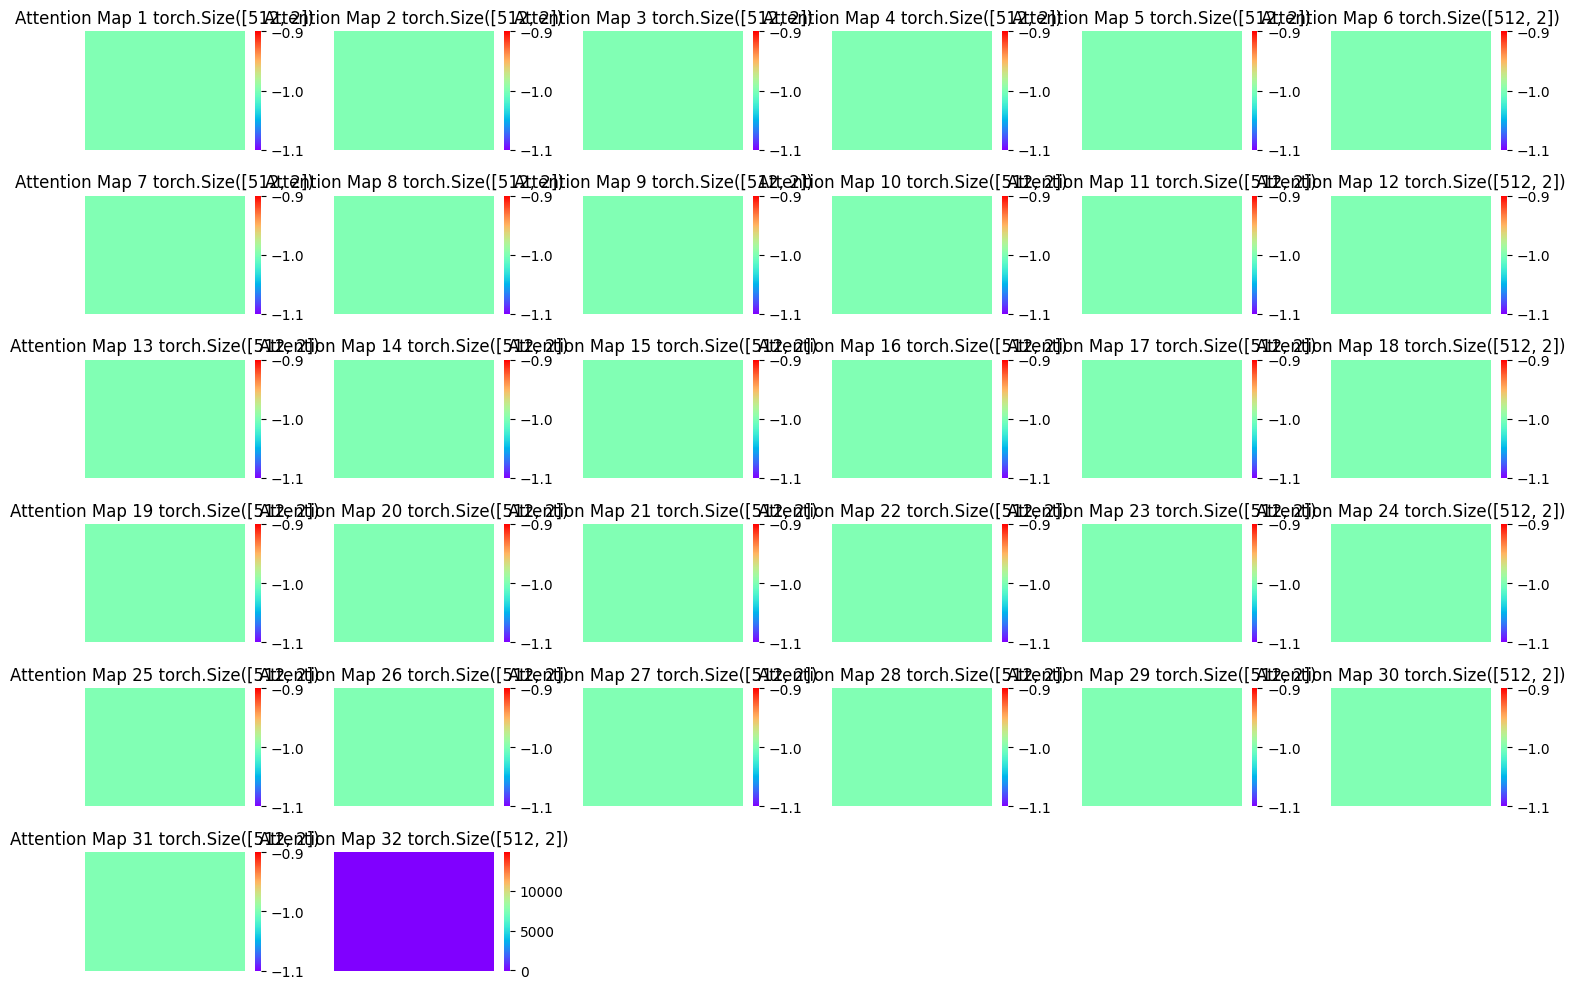

In [7]:
plot_attention_maps(long_context[0]['indices'][:,:,-2:])

In [11]:
long_context[0]['indices'][:,:,-2:][-1]

tensor([[9999999, 9999999],
        [9999999, 9999999],
        [9999999, 9999999],
        ...,
        [9999999, 9999999],
        [9999999, 9999999],
        [9999999, 9999999]])

In [72]:
import torch 
tree_k = 512
tree_stride = [16384]

default_long = []

for s in tree_stride:
    for l in [0,31]:
        default_long.append(torch.load(f'../../cache/llama/default/qkvout_s{s}_k{tree_k}_l{l}.pth', map_location=torch.device('cpu')))

In [78]:
long_context[0]['indices'].shape

torch.Size([32, 512, 542])

In [77]:
(long_context[0]['indices'] < 9999999).sum()

tensor(3470915)

In [96]:
((long_context[0]['indices'] < long_context[0]['ks'][:, :, None])&(long_context[0]['indices'] < 16384)).sum()

tensor(165194)

In [97]:
((long_context[0]['indices'] < long_context[0]['ks'][:, :, None])&(long_context[0]['indices'] < 9999999)).sum()

tensor(165194)

In [81]:
default_long[0]['k'].shape

torch.Size([1, 32, 16384, 128])

In [83]:
default_long[0]['indices'].shape

torch.Size([32, 512, 256])

In [89]:
default_long[0]['ks'][:, :, None]

tensor([[[ 32],
         [ 64],
         [ 96],
         ...,
         [256],
         [256],
         [256]],

        [[ 32],
         [ 64],
         [ 96],
         ...,
         [254],
         [254],
         [256]],

        [[ 32],
         [ 64],
         [ 96],
         ...,
         [252],
         [256],
         [256]],

        ...,

        [[ 32],
         [ 64],
         [ 96],
         ...,
         [256],
         [256],
         [256]],

        [[ 32],
         [ 64],
         [ 96],
         ...,
         [256],
         [256],
         [256]],

        [[ 32],
         [ 64],
         [ 96],
         ...,
         [252],
         [256],
         [256]]])

In [90]:
default_long[0]['indices'] < default_long[0]['ks'][:, :, None]

tensor([[[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [92]:
(default_long[0]['indices'] < 16384)

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

In [95]:
(default_long[0]['indices'] < 16384).sum()

tensor(4193900)

In [100]:
l = ((long_context[0]['indices'] < long_context[0]['ks'][:, :, None])&(long_context[0]['indices'] < 16384)).sum()

In [101]:
d = ((default_long[0]['indices'] < default_long[0]['ks'][:, :, None])&(default_long[0]['indices'] < 16384)).sum()

In [102]:
l/d

tensor(1.0385)

In [85]:
default_long[0]['ks'].shape

torch.Size([32, 512])

In [84]:
default_long[0]['ks']

tensor([[ 32,  64,  96,  ..., 256, 256, 256],
        [ 32,  64,  96,  ..., 254, 254, 256],
        [ 32,  64,  96,  ..., 252, 256, 256],
        ...,
        [ 32,  64,  96,  ..., 256, 256, 256],
        [ 32,  64,  96,  ..., 256, 256, 256],
        [ 32,  64,  96,  ..., 252, 256, 256]])

In [6]:
default_long[0]['indices']

tensor([[[    0,     2,     4,  ...,   506,   508,   510],
         [    0,     2,     4,  ...,   506,   508,   510],
         [    0,     2,     4,  ...,   506,   508,   510],
         ...,
         [11550, 11552, 11554,  ..., 16170, 16172, 16174],
         [14052, 14054, 14056,  ..., 16242, 16244, 16246],
         [12544, 12546, 12548,  ..., 16266, 16268, 16270]],

        [[    0,     2,     4,  ...,   506,   508,   510],
         [    0,     2,     4,  ...,   506,   508,   510],
         [    0,     2,     4,  ...,   506,   508,   510],
         ...,
         [12558, 12560, 12562,  ..., 16206, 16208, 16210],
         [10730, 10732, 10734,  ..., 16230, 16232, 16234],
         [12192, 12194, 12196,  ..., 16306, 16308, 16310]],

        [[    0,     2,     4,  ...,   506,   508,   510],
         [    0,     2,     4,  ...,   506,   508,   510],
         [    0,     2,     4,  ...,   506,   508,   510],
         ...,
         [ 9370,  9372,  9374,  ..., 16202, 16204, 16206],
         [

In [7]:
import torch
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Function to plot a grid of heatmaps for attention maps
def plot_attention_maps(tensor, cmap='rainbow'):
    num_attention_maps = tensor.shape[0]
    grid_cols = math.ceil(math.sqrt(num_attention_maps))
    grid_rows = math.ceil(num_attention_maps / grid_cols)
    mask = (tensor == 9999999)
    tensor = torch.where(mask, -1, tensor)
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        if i < tensor.shape[0]:
            sns.heatmap(tensor[i][:], ax=ax, cmap=cmap, cbar=True)
            ax.set_title(f'Attention Map {i+1} {tensor[i].shape}')
            ax.axis('off')  # Optional: Hide the axis ticks
        else:
            ax.axis('off')  # Hide unused plots
    plt.tight_layout()
    plt.show()

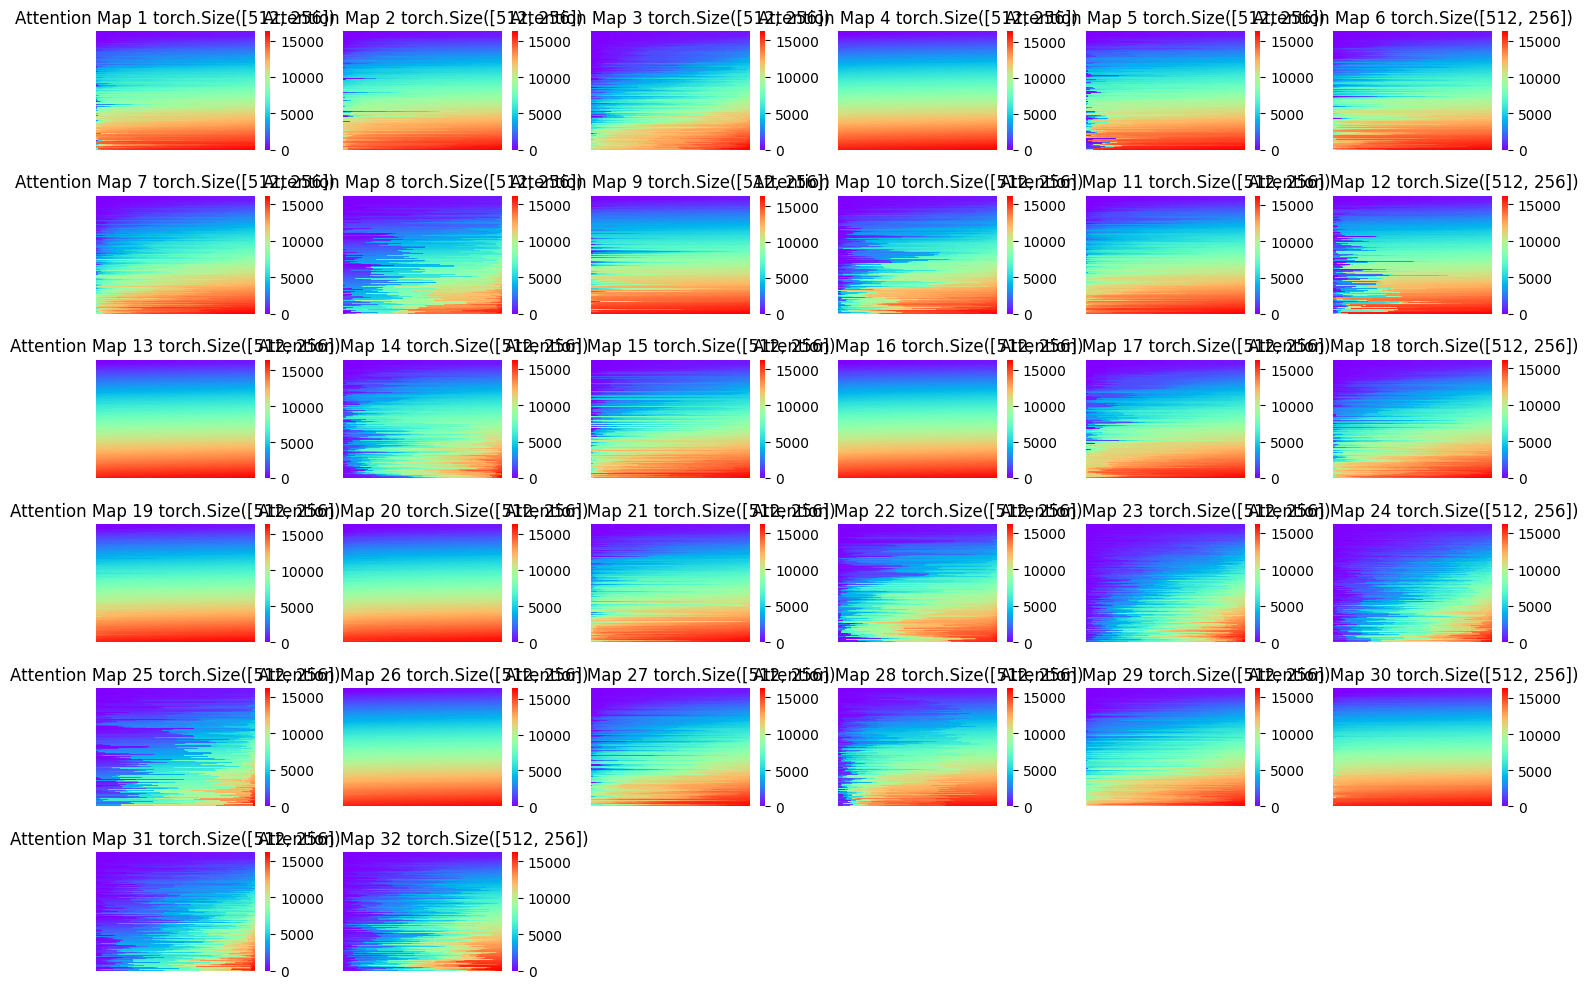

In [9]:
plot_attention_maps(default_long[0]['indices'])

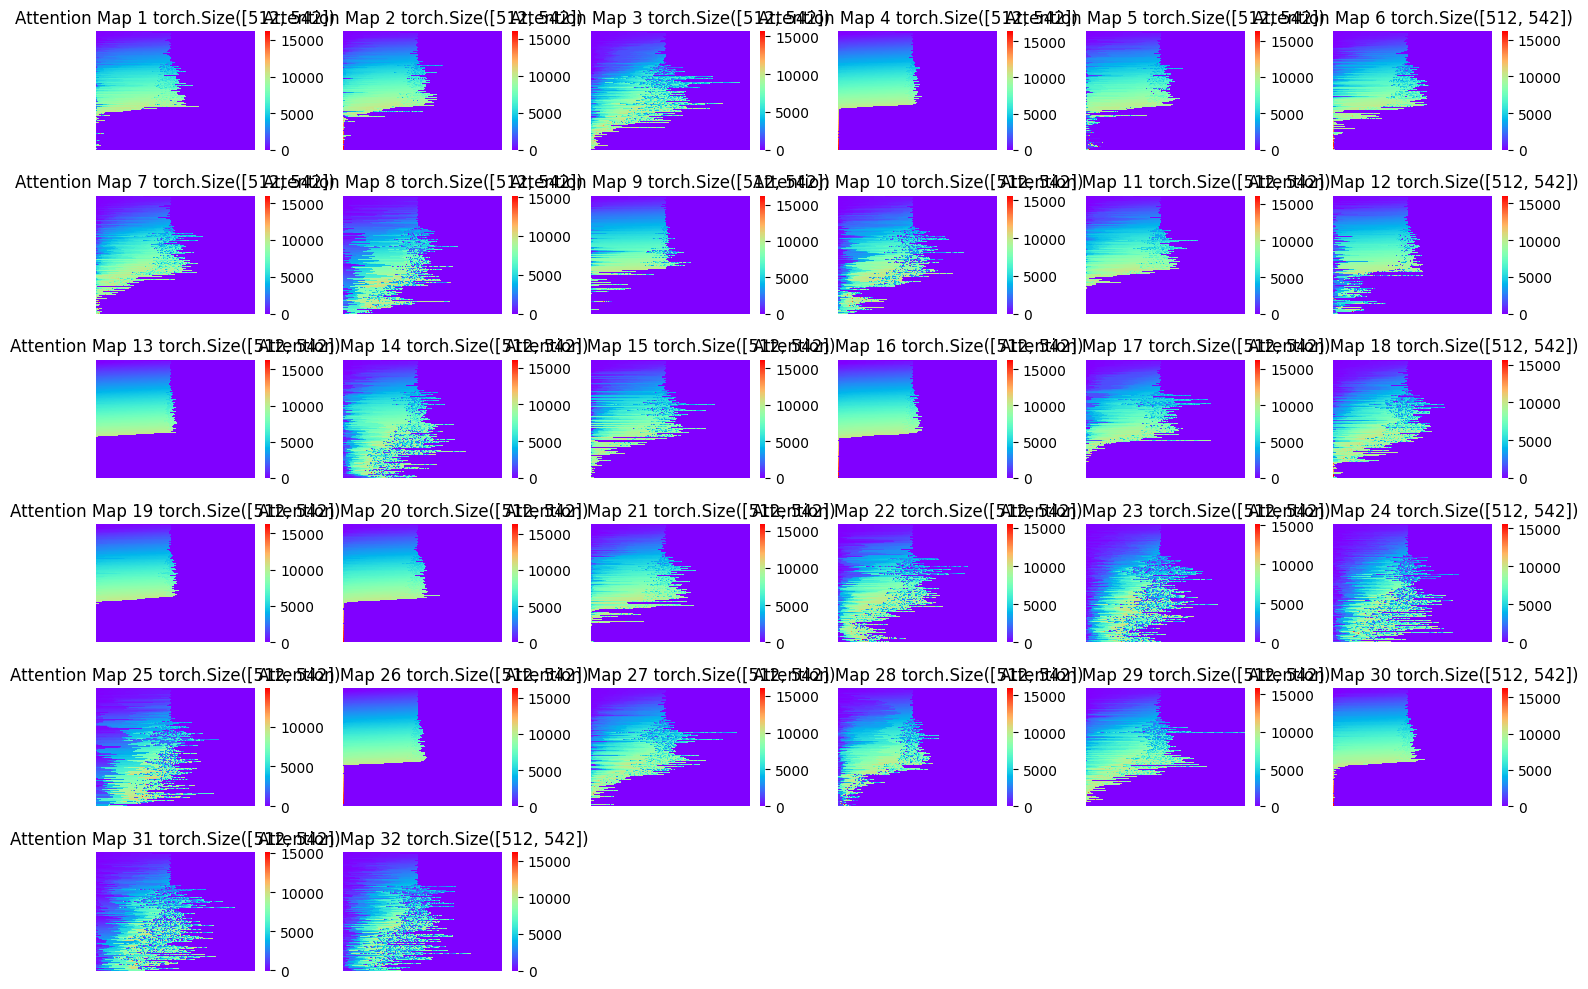

In [103]:
plot_attention_maps(long_context[0]['indices'])


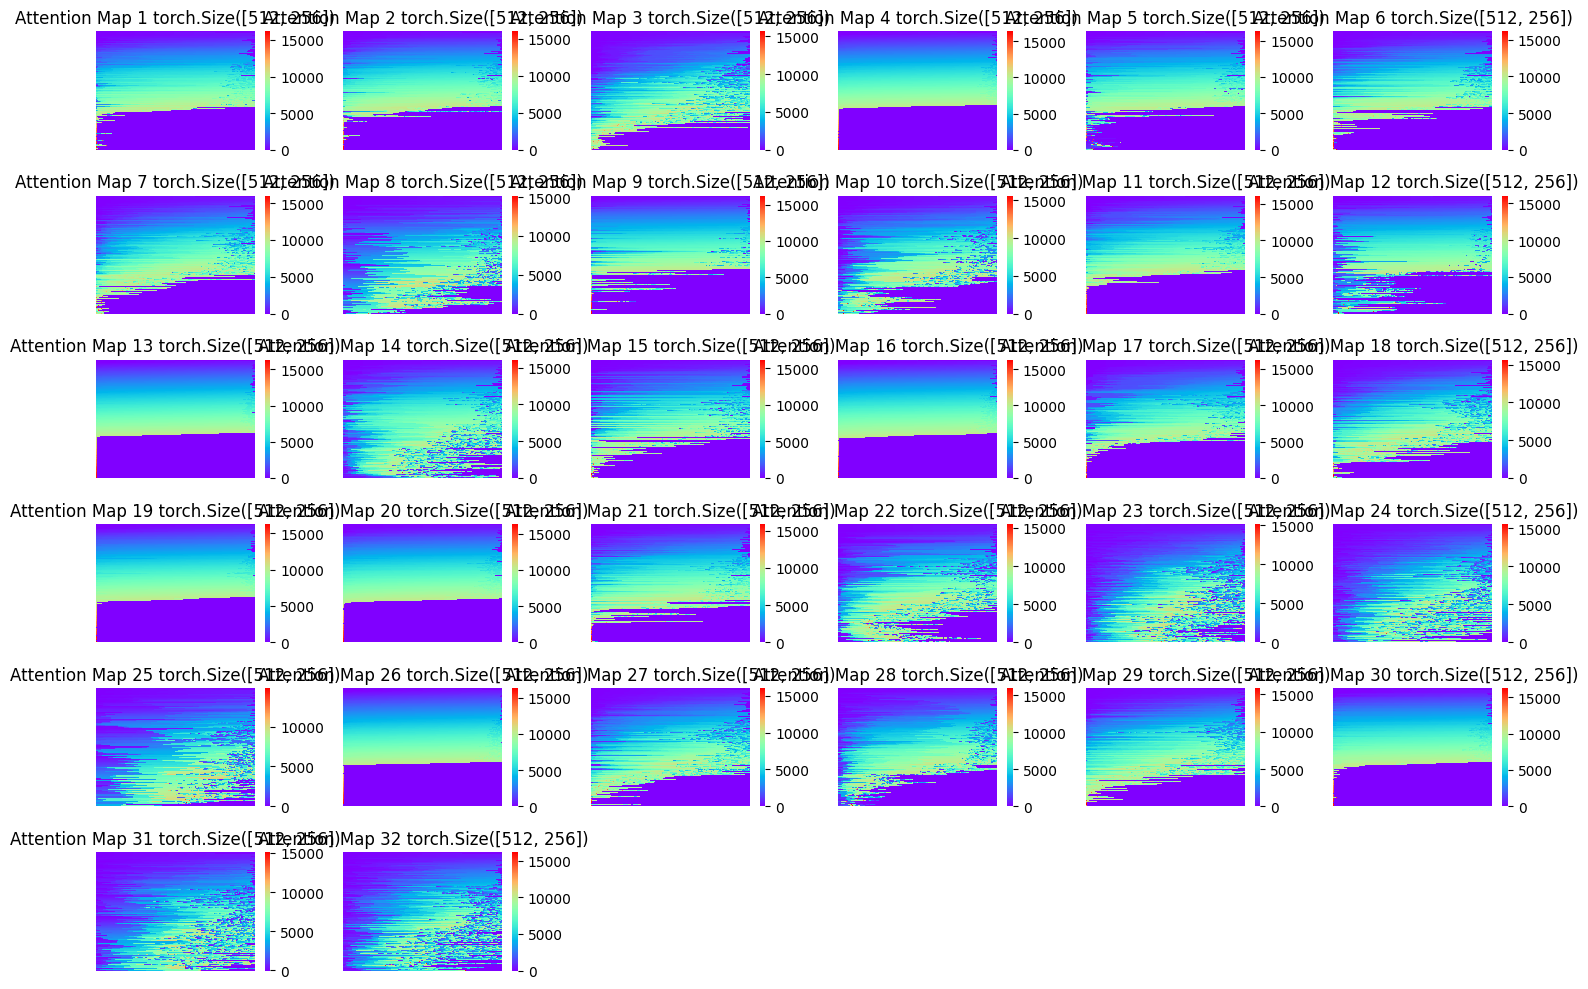

In [106]:
plot_attention_maps(long_context[0]['indices'][:,:, :256])

In [16]:
long_context[0]

{'q': tensor([[[[ 0.1309, -0.7539,  1.3359,  ..., -0.5312,  0.2080, -0.7930],
           [ 0.5781, -0.5312,  0.7461,  ..., -0.7578,  0.4082, -0.8594],
           [ 0.7266, -0.5820,  0.7578,  ..., -0.7578,  0.4082, -0.8594],
           ...,
           [-1.3047, -1.9062, -1.8281,  ..., -0.6836,  0.1631, -0.8828],
           [-0.7891, -2.2812, -2.5000,  ..., -1.3359,  0.6719, -1.4375],
           [-0.2461, -1.9297, -2.2344,  ..., -1.2266,  0.6641, -1.3438]],
 
          [[ 0.5742,  0.1260, -1.4844,  ..., -0.5234,  0.3145, -0.5078],
           [ 2.4062,  1.7031, -0.8047,  ..., -0.2422,  0.1660, -0.2275],
           [ 2.1562,  1.5000, -0.8711,  ..., -0.2422,  0.1660, -0.2275],
           ...,
           [ 0.1260, -0.2441,  0.2275,  ..., -0.1855, -0.4316, -0.0732],
           [-0.0078,  0.0085,  0.4043,  ...,  0.1680, -0.4629,  0.1777],
           [-0.0474,  0.1621,  0.5312,  ...,  0.1543, -0.3867,  0.1572]],
 
          [[-0.7812, -0.7305, -0.7031,  ..., -0.4277, -0.3750, -0.3691],
        

In [33]:
((long_context[0]['indices']==9999999).view(-1, 542)[:, 0]).sum()

tensor(136)

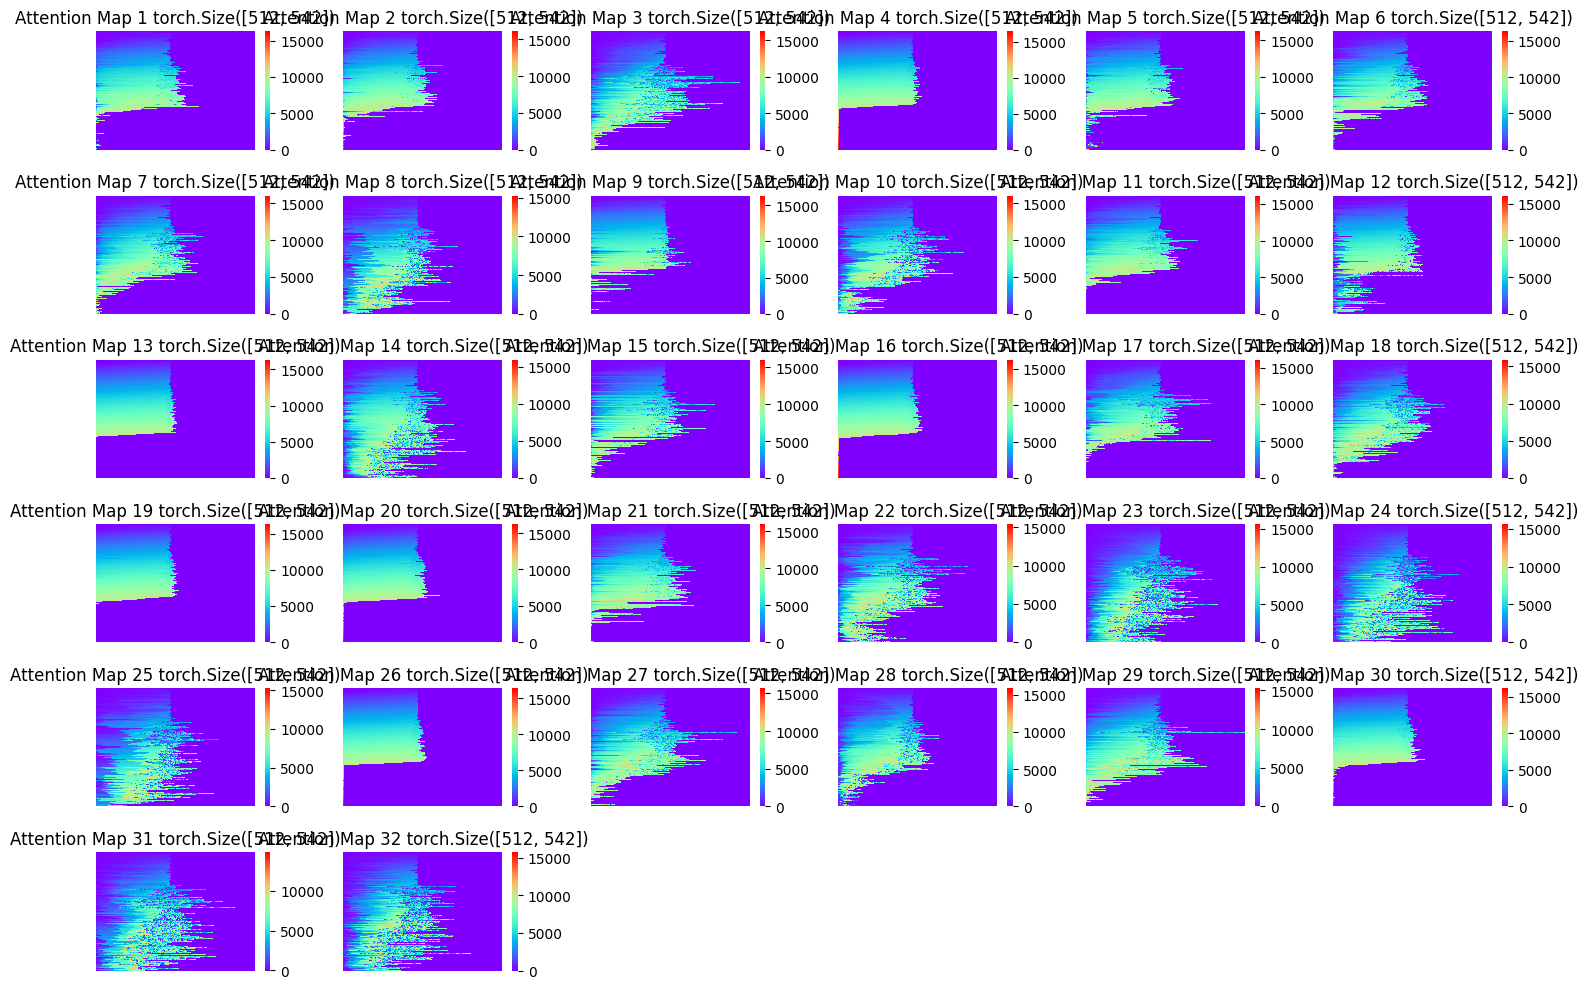

In [19]:
plot_attention_maps(long_context[0]['indices'][:,:,:])


In [41]:
MASK_K_BK = 10
indices = 
range_tensor = torch.arange(MASK_K_BK).expand_as(indices)
print(range_tensor)

NameError: name 'indices' is not defined

In [70]:
(long_context[0]['ks']).max()

tensor(542)

In [59]:
(long_context[0]['ks'] >= 512).sum()

tensor(3)

In [63]:
long_context[0]['ks'].shape

torch.Size([32, 512])

In [64]:
32*512

16384

In [56]:
(long_context[0]['ks']).max(dim=1)[0]

tensor([368, 341, 510, 284, 356, 457, 387, 392, 341, 428, 386, 344, 278, 424,
        472, 296, 497, 448, 299, 330, 418, 526, 487, 505, 479, 300, 500, 409,
        542, 317, 484, 513])

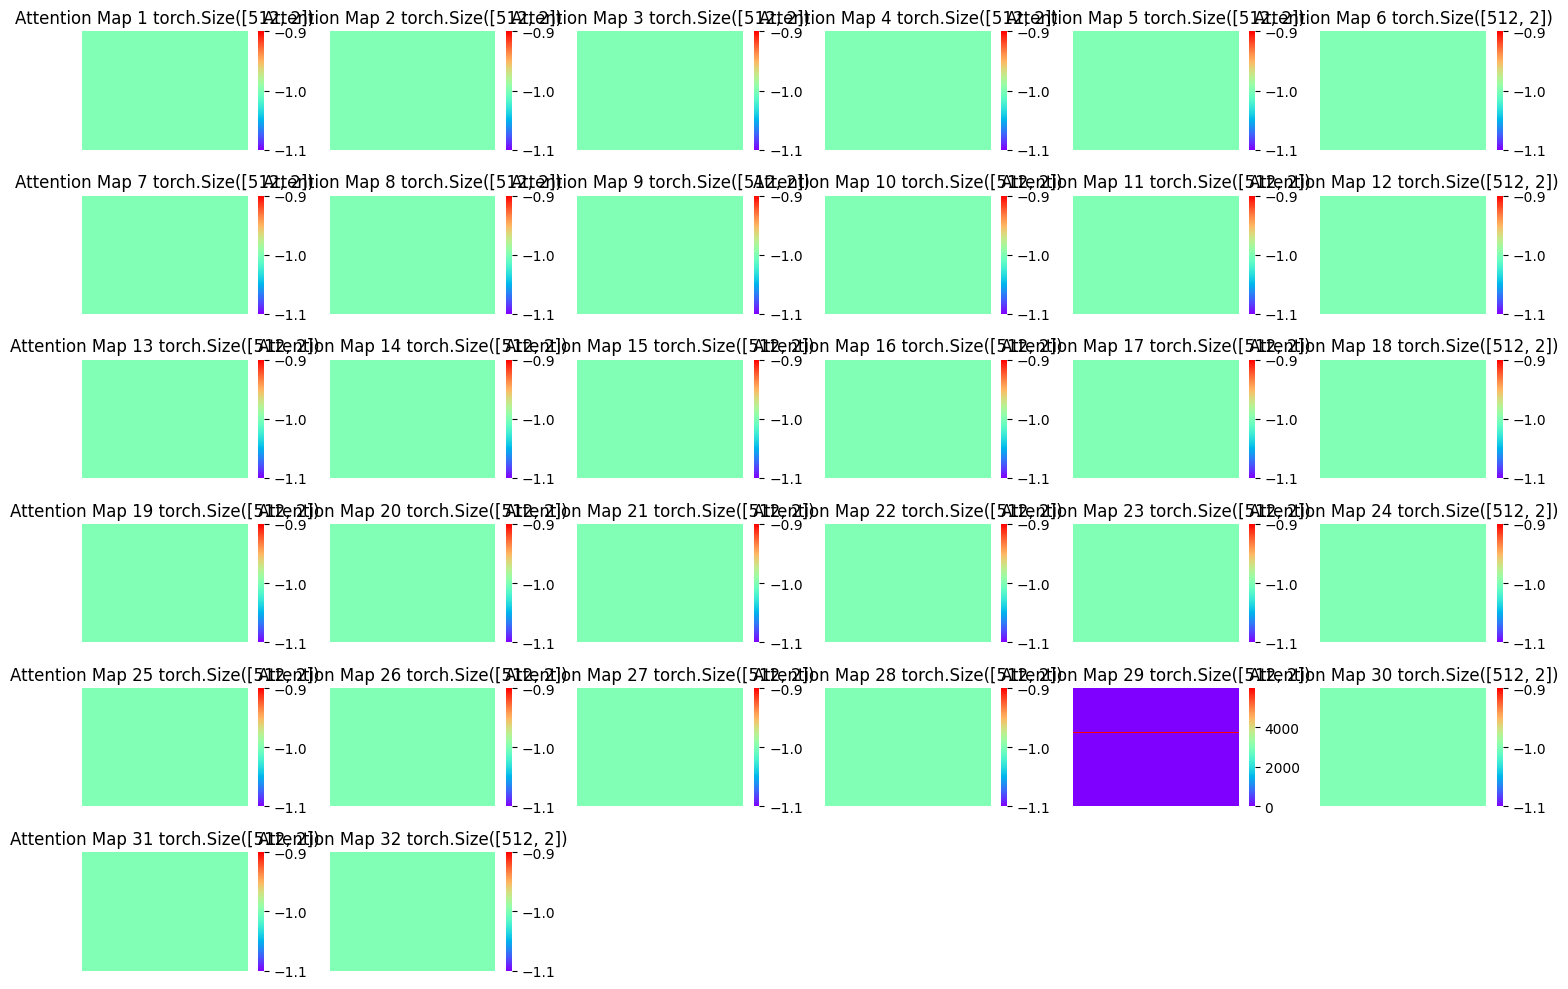

In [18]:
plot_attention_maps(long_context[0]['indices'][:,:,-2:])


In [10]:
default_long[0]['k'].shape

torch.Size([1, 32, 16384, 128])

In [39]:
(long_context[0]['indices'] <16384).sum() / (default_long[0]['indices'] < 16384).sum()

tensor(0.8276)

In [35]:
(long_context[0]['indices'] <9999999).sum()

tensor(3470957)

In [13]:
(default_long[0]['indices'] < 16384).sum()

tensor(4193900)

In [36]:
for l in long_context:
    print(l['indices'].shape)

torch.Size([32, 384, 423])
torch.Size([32, 384, 256])
torch.Size([32, 384, 433])
torch.Size([32, 384, 256])
torch.Size([32, 512, 423])
torch.Size([32, 512, 256])
torch.Size([32, 512, 433])
torch.Size([32, 512, 256])


In [12]:
long_context[0]['indices'].shape

torch.Size([32, 384, 423])

In [37]:
import torch
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Function to plot a grid of heatmaps for attention maps
def plot_attention_maps(tensor, cmap='rainbow'):
    num_attention_maps = tensor.shape[0]
    grid_cols = math.ceil(math.sqrt(num_attention_maps))
    grid_rows = math.ceil(num_attention_maps / grid_cols)
    mask = (tensor == 9999999)
    tensor = torch.where(mask, -1, tensor)
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        if i < tensor.shape[0]:
            sns.heatmap(tensor[i][:], ax=ax, cmap=cmap, cbar=True)
            ax.set_title(f'Attention Map {i+1} {tensor[i].shape}')
            ax.axis('off')  # Optional: Hide the axis ticks
        else:
            ax.axis('off')  # Hide unused plots
    plt.tight_layout()
    plt.show()

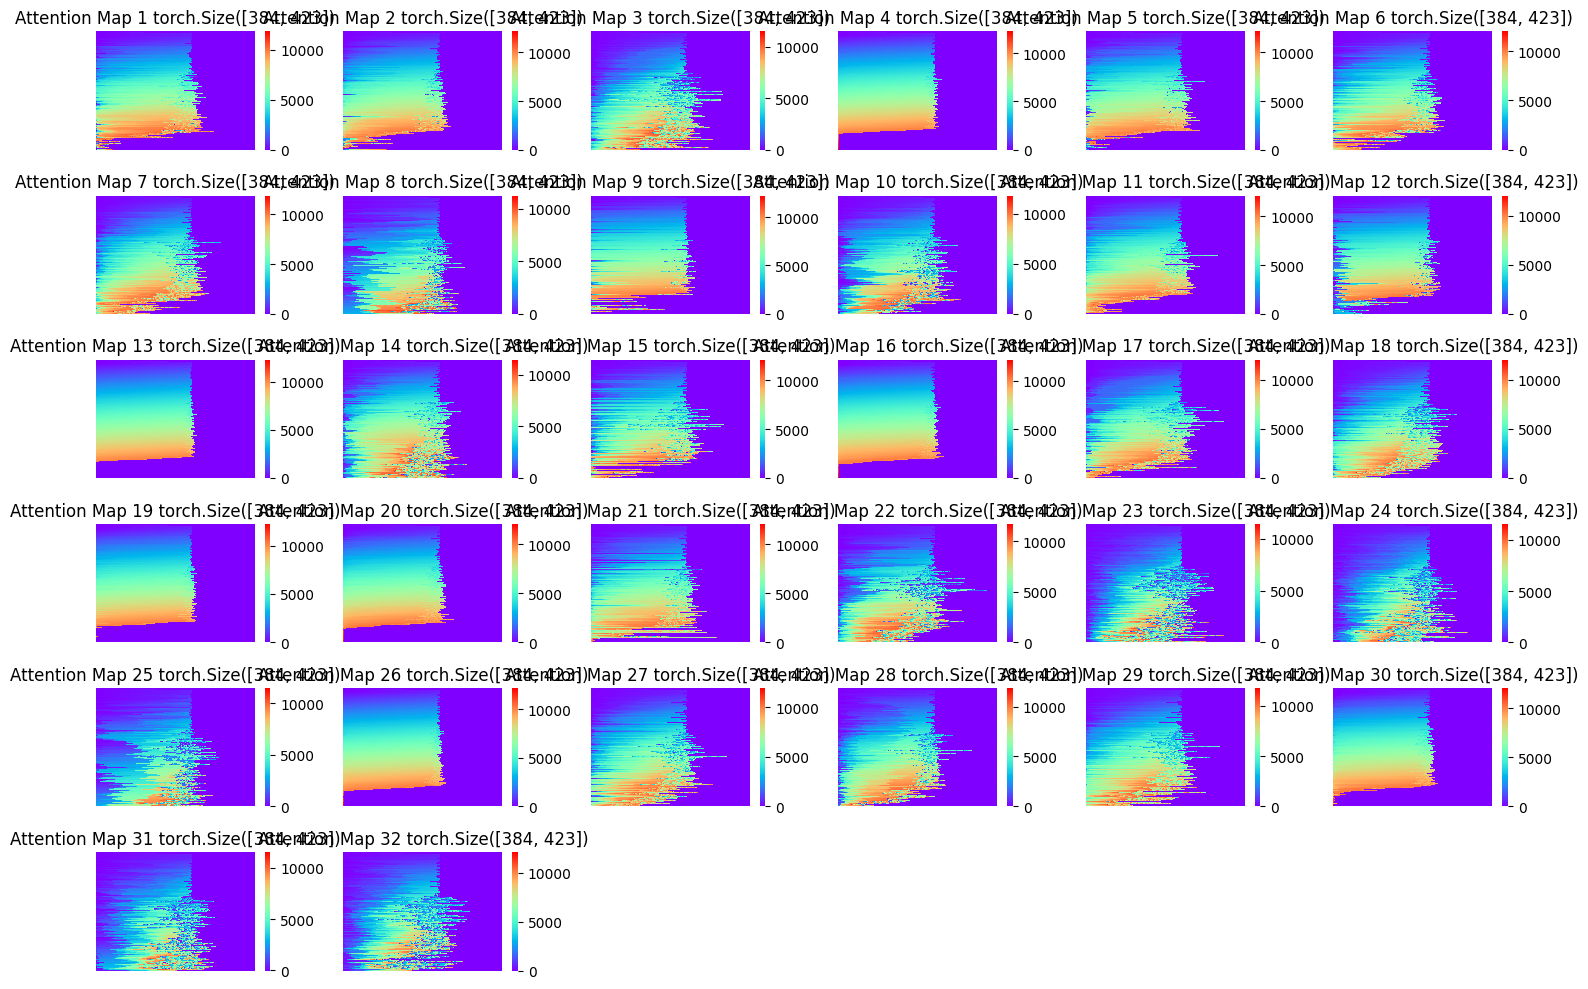

In [15]:
plot_attention_maps(long_context[0]['indices'], cmap='rainbow')  # Change cmap as needed

In [31]:
def find_first_32000(tensor):
    filtered_mask = tensor != 9999999

    # print(filtered_mask.shape, filtered_mask, filtered_mask.sum(-2).shape, )
    # print(filtered_mask.sum(-2))

    is_zero = filtered_mask.sum(-2) == 0

    # Determine which columns have all zeros
    columns_with_all_zeros = torch.all(is_zero, dim=0)

    # Find the first index where all values in a column are zero
    first_column_with_all_zeros = torch.nonzero(columns_with_all_zeros, as_tuple=True)

    # If there is at least one column with all zeros, get the first one
    if len(first_column_with_all_zeros[0]) > 0:
        first_index = first_column_with_all_zeros[0][0].item()  # Get the index of the first such column
    else:
        first_index = -1  # If no columns contain all zeros

    print("First index where all values are zero:", first_index)

In [32]:
for tl in long_context:
    find_first_32000(tl['indices'])

First index where all values are zero: -1
First index where all values are zero: -1
First index where all values are zero: -1
First index where all values are zero: -1
First index where all values are zero: -1
First index where all values are zero: -1
First index where all values are zero: -1
First index where all values are zero: -1


In [28]:
mask = (long_context[0]['indices'][2,:, -2:]==9999999)
tensor = torch.where(mask, -1, long_context[0]['indices'][2,:, -2:])

In [29]:
tensor

tensor([[-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.000

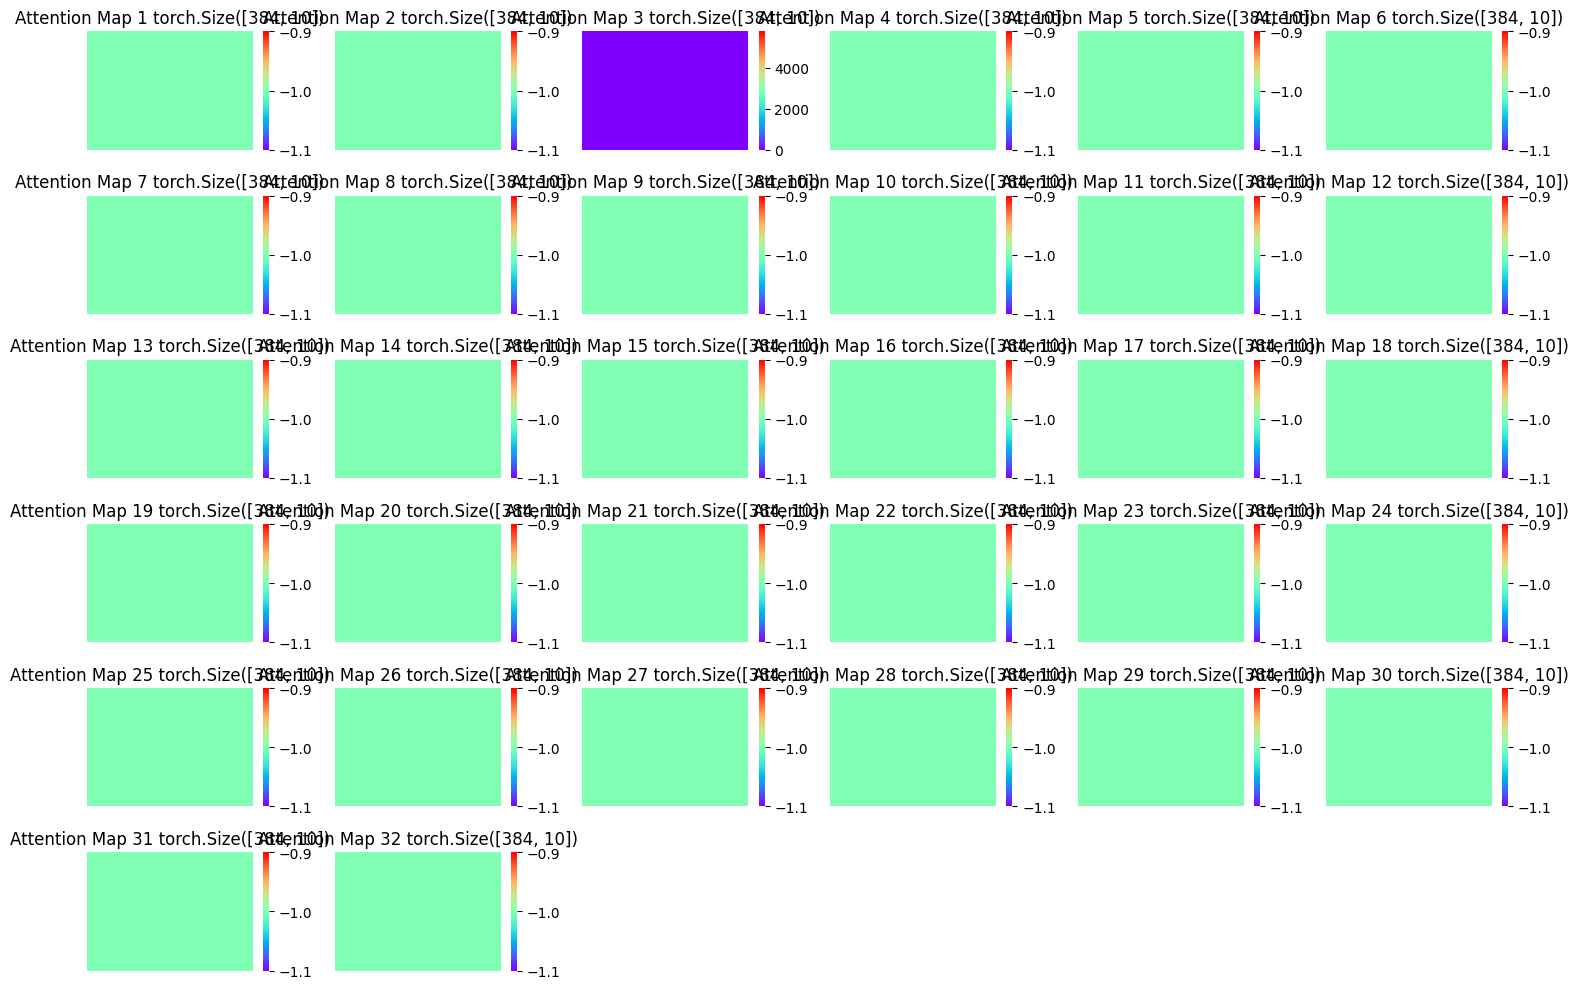

In [30]:
plot_attention_maps(long_context[0]['indices'][:,:, -10:], cmap='rainbow')  # Change cmap as needed

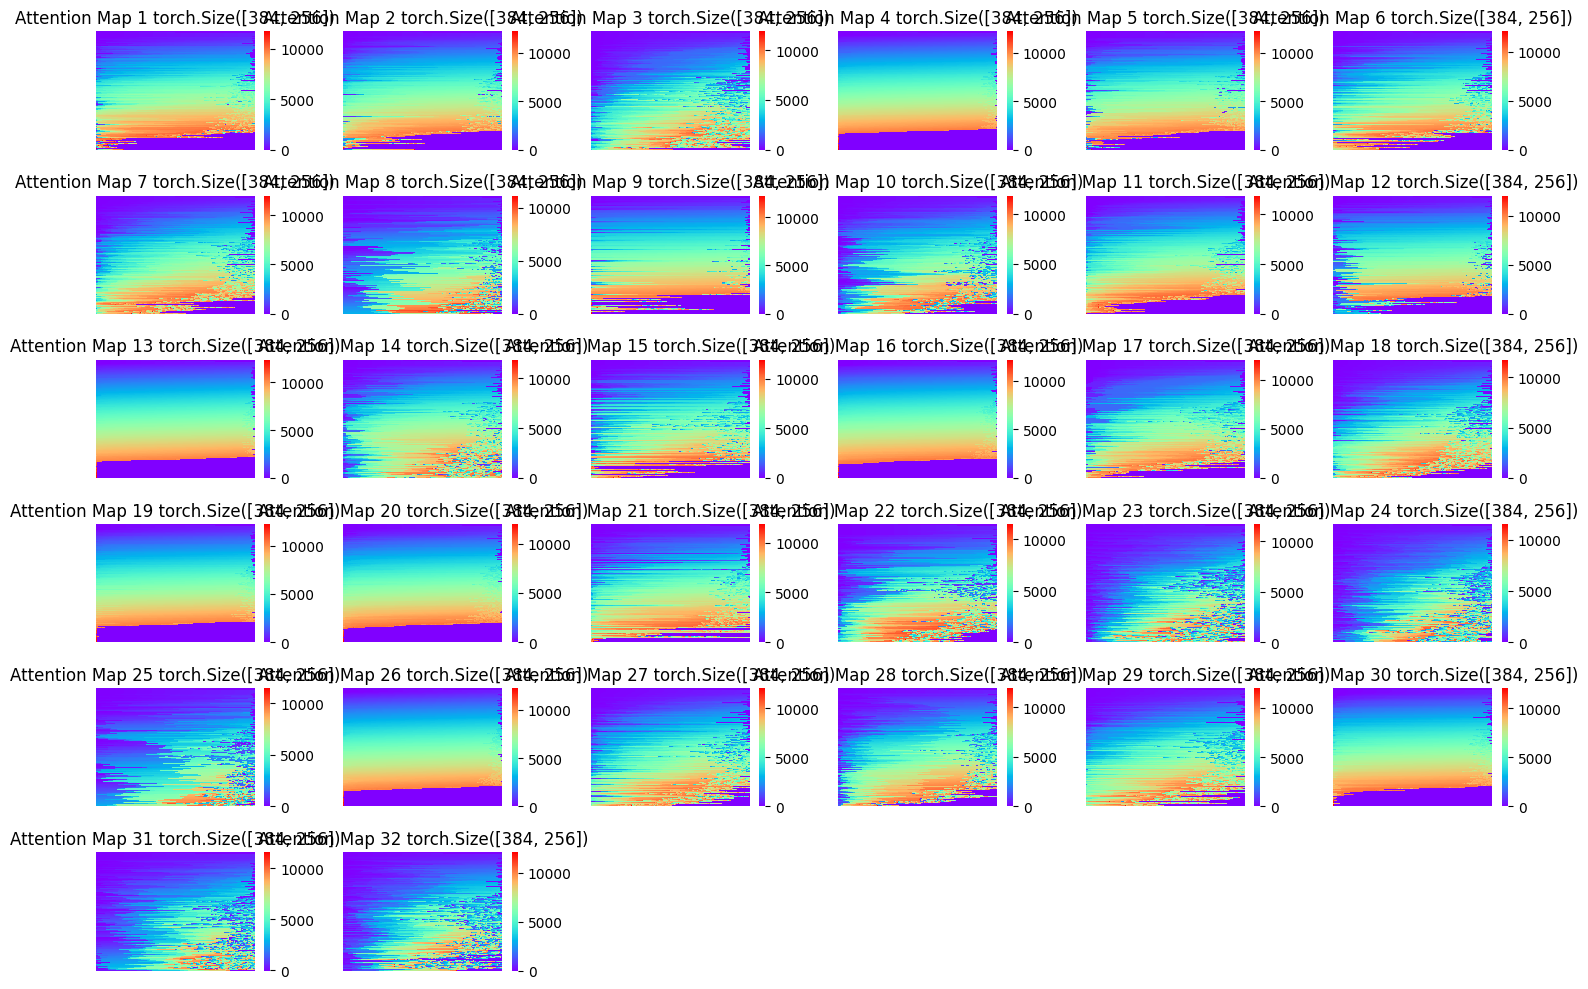

In [38]:
plot_attention_maps(long_context[1]['indices'], cmap='rainbow')  # Change cmap as needed


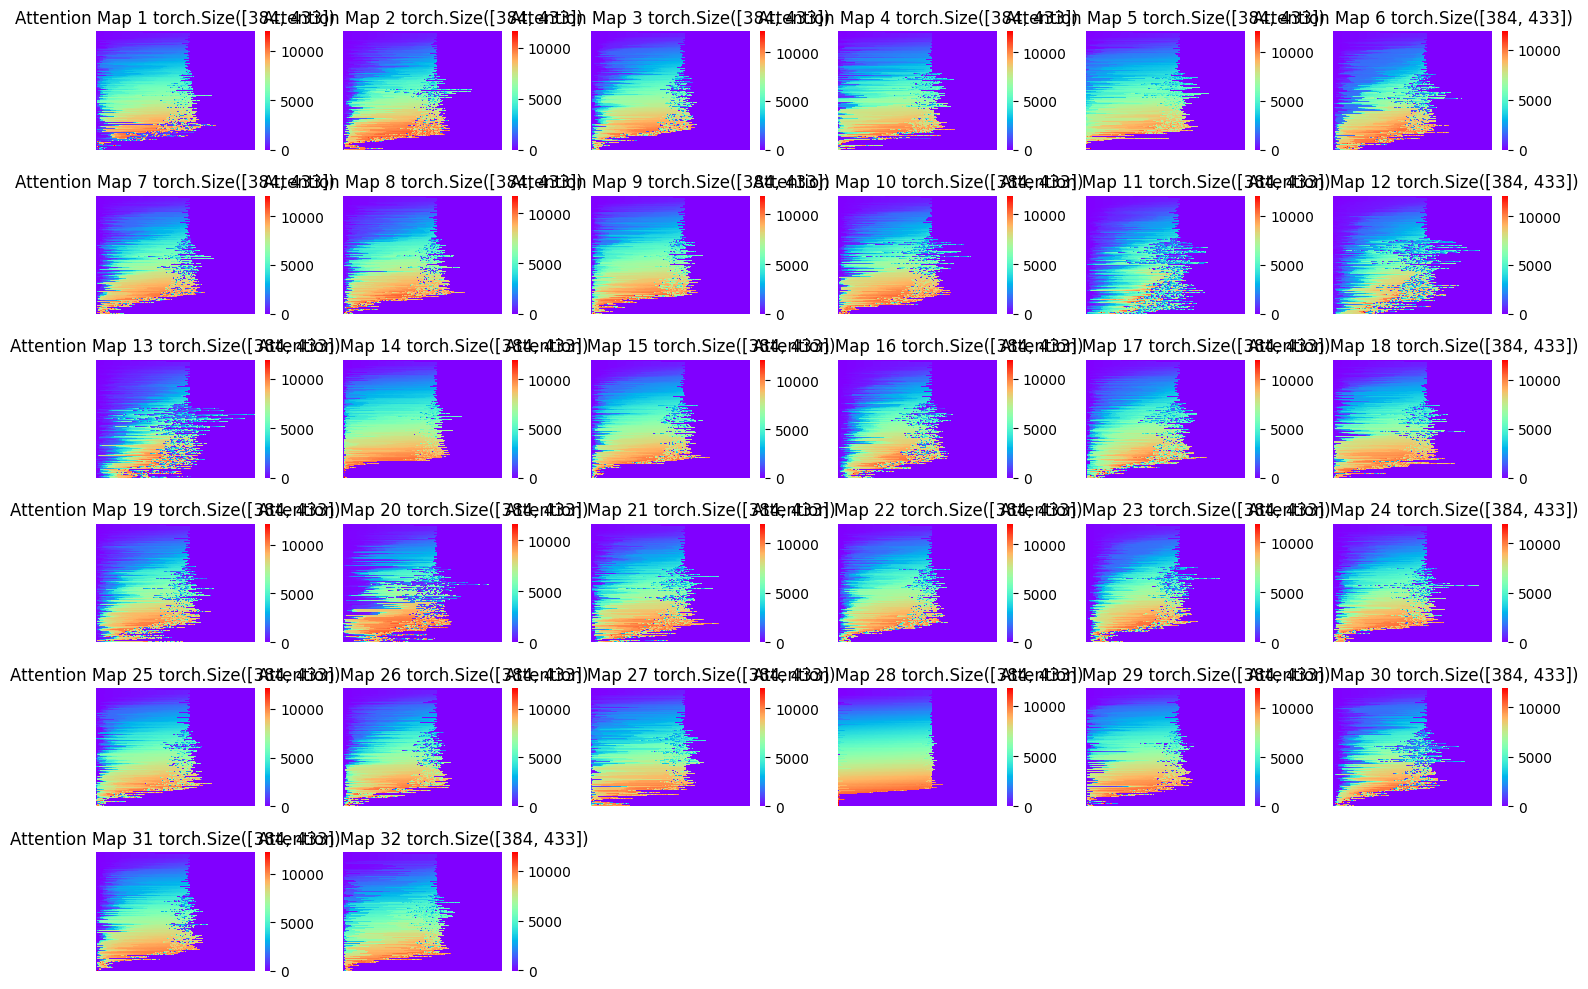

In [39]:
plot_attention_maps(long_context[2]['indices'], cmap='rainbow')  # Change cmap as needed


FileNotFoundError: [Errno 2] No such file or directory: './cache/llama/default/qkvout_k512_s12288_l0.pth'